# Mixup 실습

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np 

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 모델 정의 

In [2]:
class MyModel(nn.Module) : 
    def __init__(self) :
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(16 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x) :
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

## 데이터 정의

In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.3,0.3,0.3))
])


train_dataset = datasets.CIFAR10(root='./CIFAR10_data', train=True, transform = train_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10_data\cifar-10-python.tar.gz to ./CIFAR10_data


In [4]:
model = MyModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [5]:
def mixup_data(x, y, alpha=1.0) :
    batch_size = x.size(0) 
    lam = torch.rand(batch_size, 1, 1, 1)  
    lam = torch.max(lam, 1 - lam) 
    mixed_x = lam * x + (1 - lam) * x.flip(dims=[0,2,3]) 
    
    indices = torch.randperm(batch_size) 
    mixed_y = lam.squeeze() * y + ( 1 - lam.squeeze()) * y[indices] 
    mixed_y = mixed_y.type(torch.long) 
    
    return mixed_x, mixed_y

In [6]:
def plot_images(images, labels, title) : 
    fig, axes = plt.subplots(2, 5 , figsize=(12,6))
    fig.suptitle(title, fontsize=16)
    labels = labels.numpy()
    for i, ax in enumerate(axes.flat) :
        image = images[i].squeeze()
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label:{labels[i]}")
        ax.axis('off')
        
    plt.show()

### 학습 loop 만들기 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

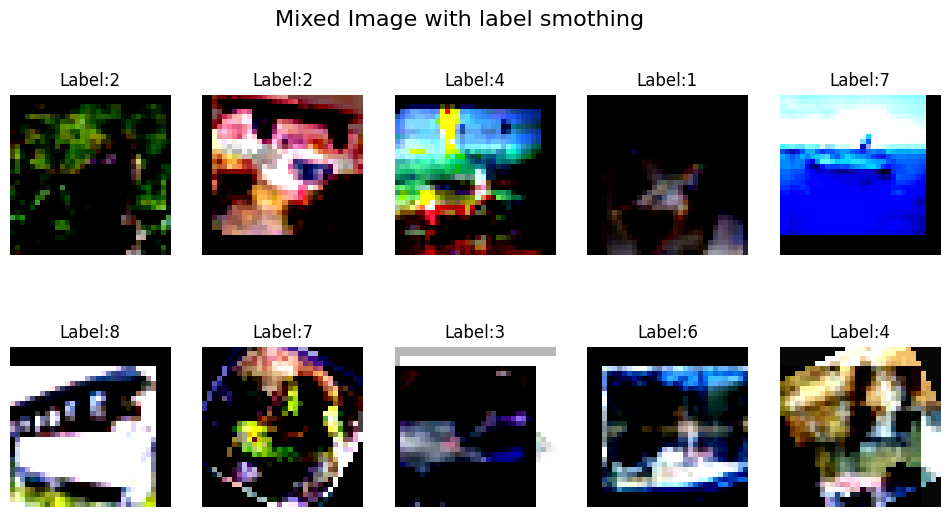

In [7]:
num_epochs = 10

train_losses_no_mixup = []
train_losses_with_mixup = []

end_idx = 0
for epoch in range(num_epochs) : 
    train_loss_no = 0.0
    train_loss = 0.0
    
    for inputs, labels in train_loader : 
        optimizer.zero_grad()
        
        images_temp, labels_tmep = inputs, labels
        
        inputs, labels = mixup_data(inputs, labels)
        
        mixed_images = inputs.cpu().numpy()
        mixed_images = np.transpose(mixed_images, (0,2,3,1))
        mixed_images = np.squeeze(mixed_images)
        
        if end_idx == 0 :
            plot_images(mixed_images, labels.squeeze(), "Mixed Image with label smothing")
            end_idx = 1 
        
        outputs_no_mixup = model(images_temp)
        outputs_mixup = model(inputs)
        
        labels = torch.squeeze(labels) # conver lables to 1D tensor 
        
        loss_no_mixup = criterion(outputs_no_mixup, labels)
        
        loss_mixup = criterion(outputs_mixup, labels)
        
        loss_no_mixup.backward()
        loss_mixup.backward()
        
        optimizer.step()
        
        train_loss_no += loss_no_mixup.item()
        train_loss += loss_mixup.item()
        
    # 에포크 마다 손실 기록 
    train_losses_no_mixup.append(train_loss_no / len(train_loader))
    train_losses_with_mixup.append(train_loss / len(train_loader))

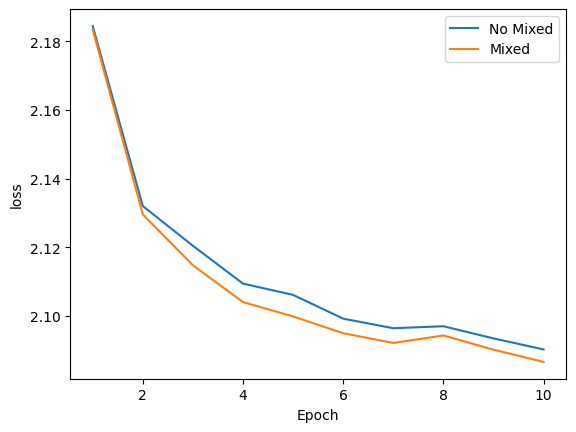

In [8]:
epochs = range(1, num_epochs +1 )

plt.plot(epochs, train_losses_no_mixup, label='No Mixed')
plt.plot(epochs, train_losses_with_mixup, label='Mixed')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()